<a href="https://colab.research.google.com/github/nourwalid70/Cartoonifying-and-road-lane-detection/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage, misc
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 1 : Image Cartoonifying 

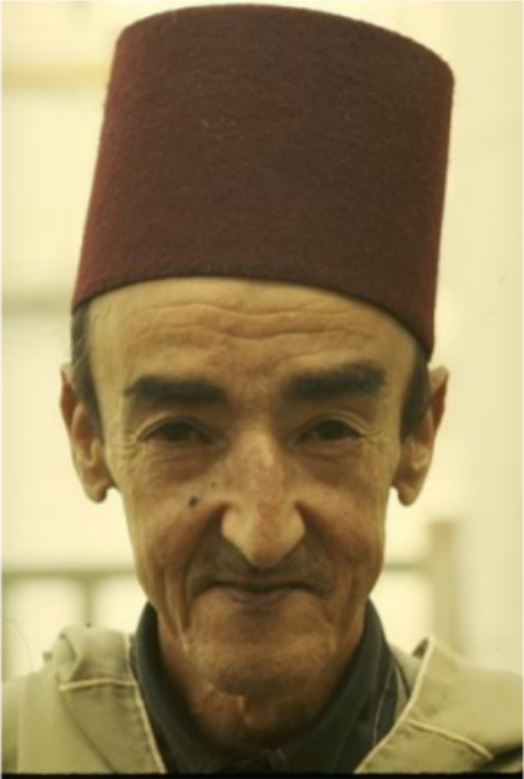

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/CV lab1/original.PNG')
cv2_imshow(img)

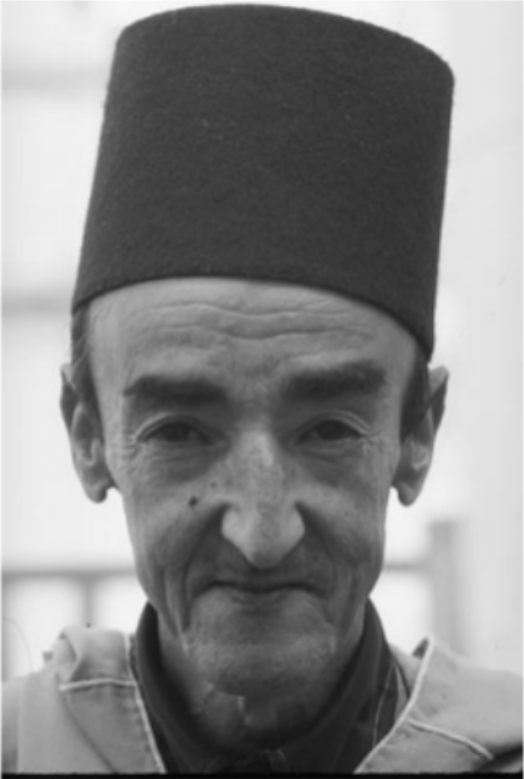

In [ ]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_img)

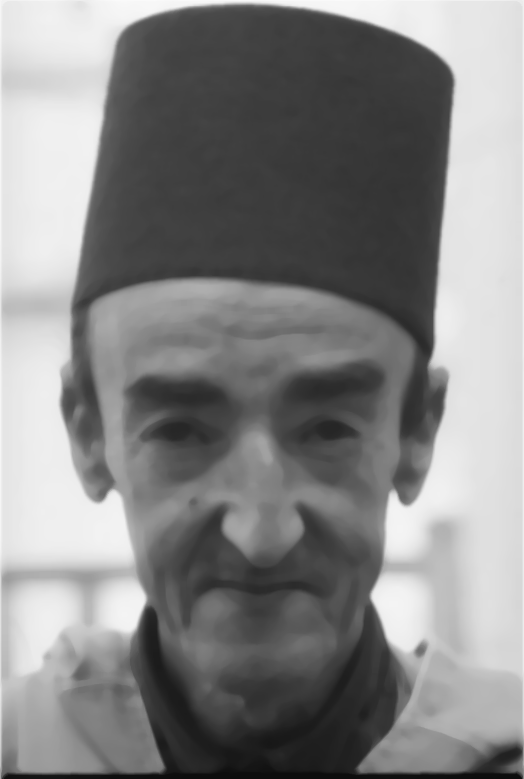

In [ ]:
blur_img=cv2.medianBlur(gray_img,11)
cv2_imshow(blur_img)

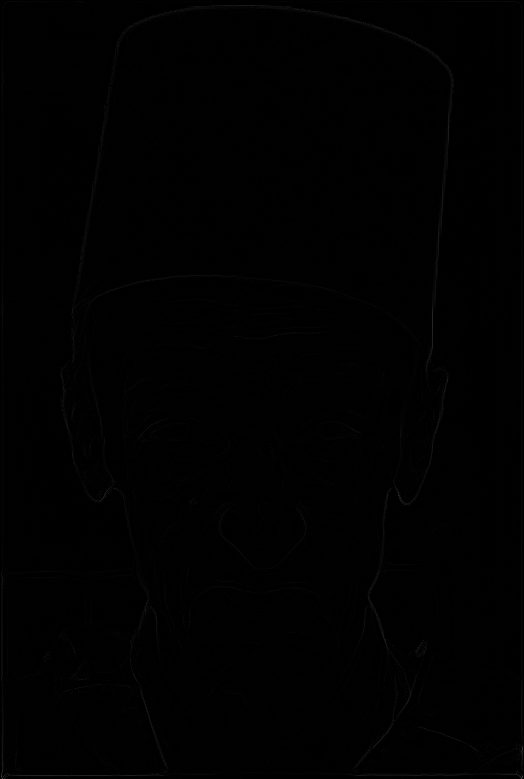

In [ ]:
laplacian_img=cv2.Laplacian(blur_img,cv2.CV_64F)
cv2_imshow(laplacian_img)

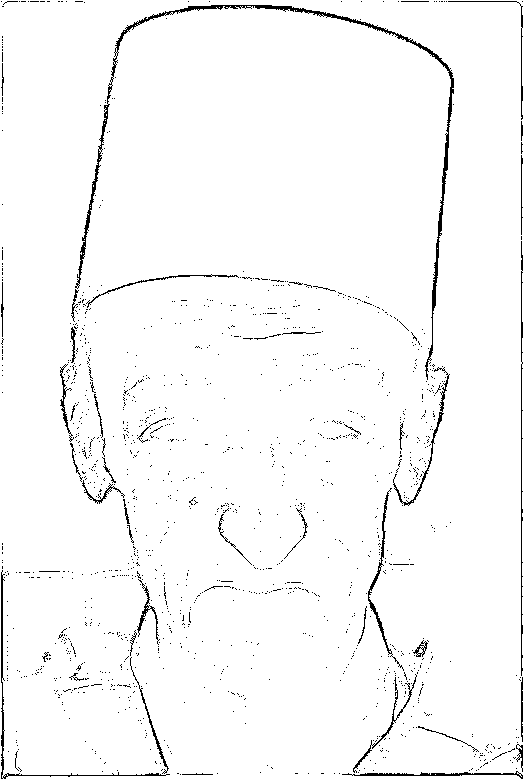

In [ ]:
threshold,threshold_img = cv2.threshold(laplacian_img,4,255,cv2.THRESH_BINARY_INV)
cv2_imshow(threshold_img)

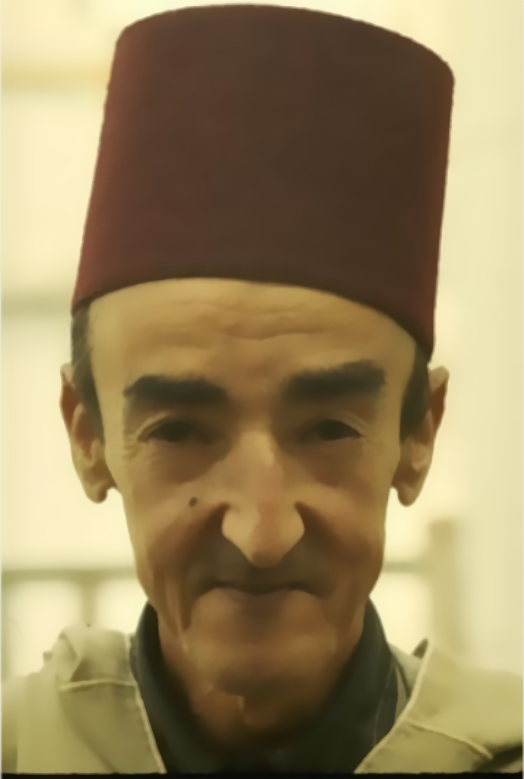

In [ ]:
bi_img= cv2.bilateralFilter(img,20,40,70)
cv2_imshow(bi_img)

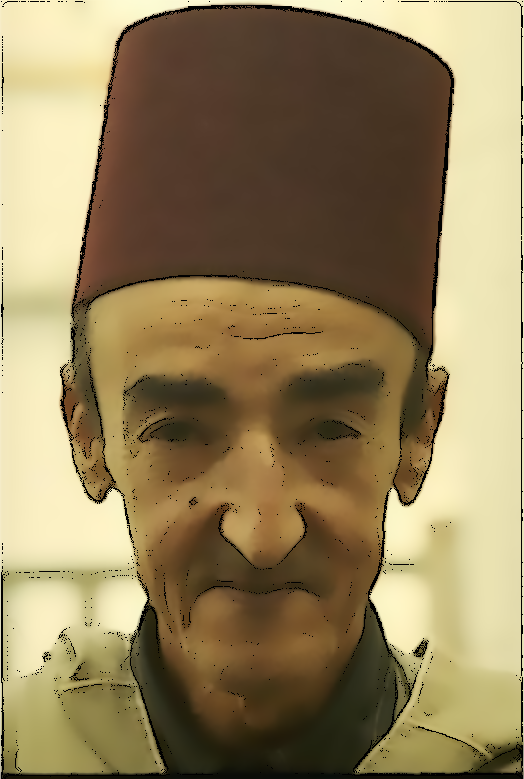

In [ ]:
output=np.zeros_like(img)
output[threshold_img == 255] =  bi_img[threshold_img == 255]
cv2_imshow(output)

# Part 2: Hough Transform

In [ ]:
img1 =  cv2.imread("/content/drive/MyDrive/Colab Notebooks/CV lab1/testHough.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/CV lab1/testHough1.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Plot images

In [ ]:
def plot2(img1, img2, tit1, tit2, cmap1=None, cmap2=None):
  plt.figure(figsize=(50,50))
  plt.subplot(121),plt.imshow(img1, cmap=cmap1),plt.title(tit1, fontsize=50)
  plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(img2, cmap=cmap2),plt.title(tit2,fontsize=50)
  plt.xticks([]), plt.yticks([])
  plt.show()

# Median filter

In [ ]:
def median_filter(img, bluring):
  median = cv2.medianBlur(img,bluring)
  return median

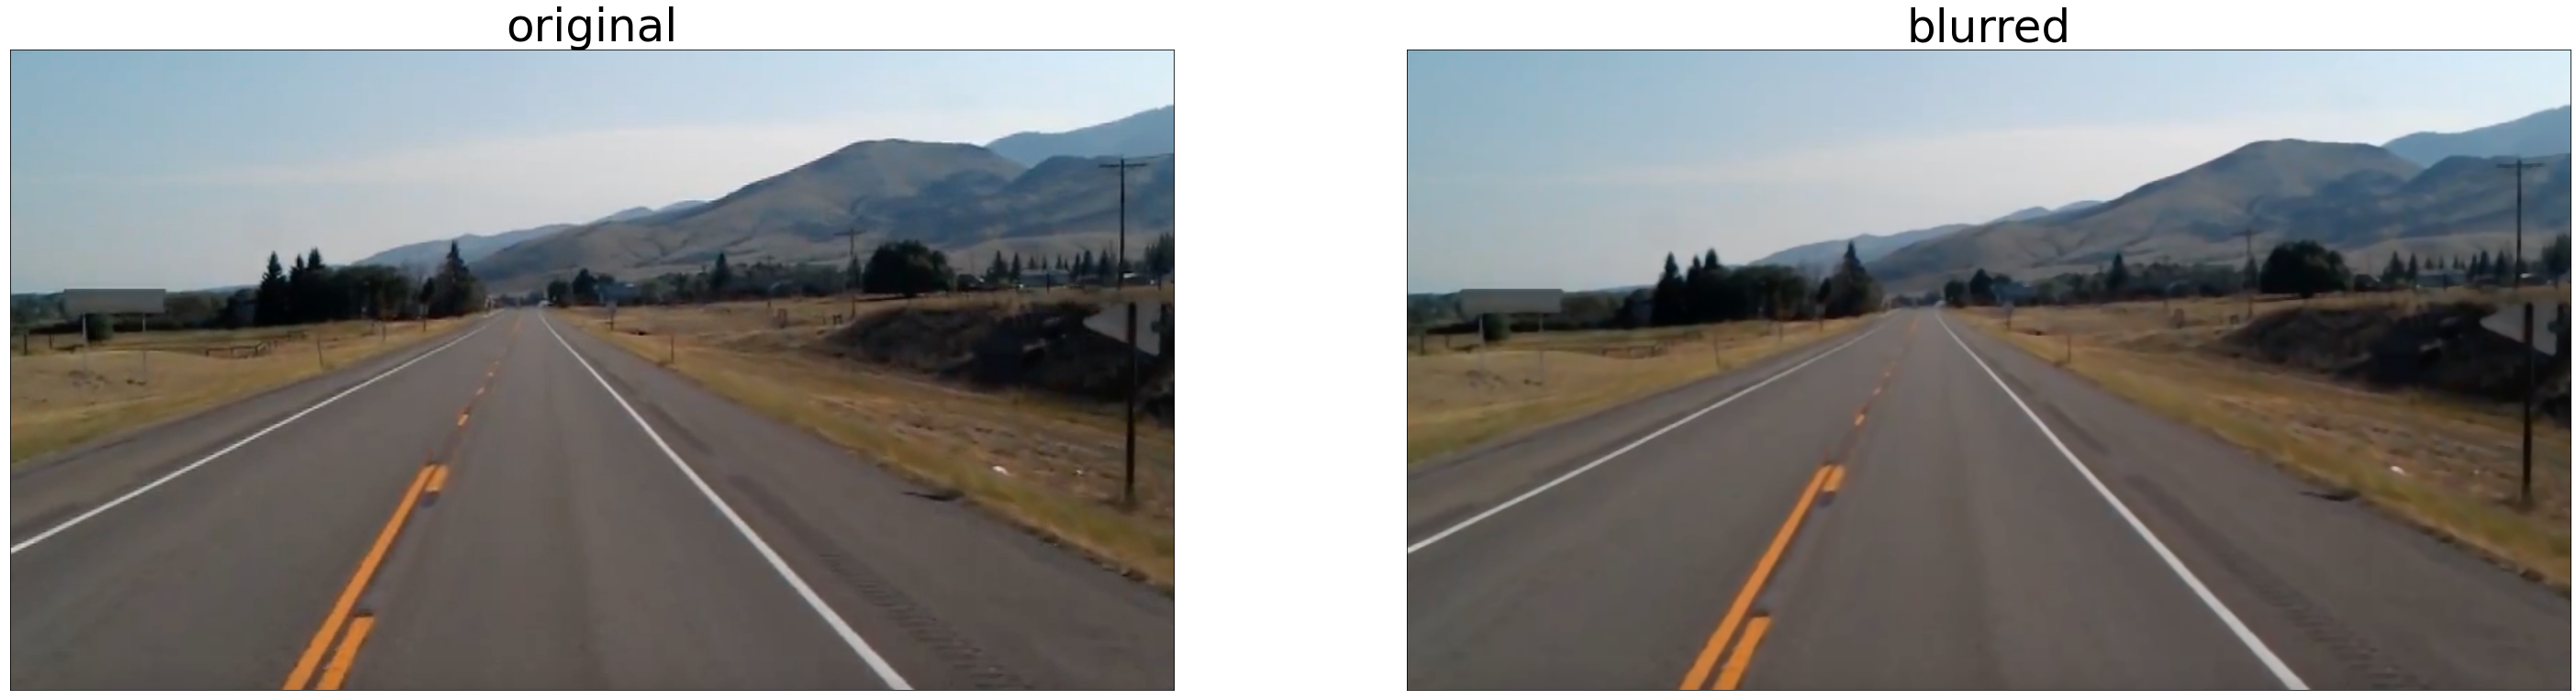

In [ ]:
median1 = median_filter(img1,5)
plot2(img1, median1, 'original', 'blurred')

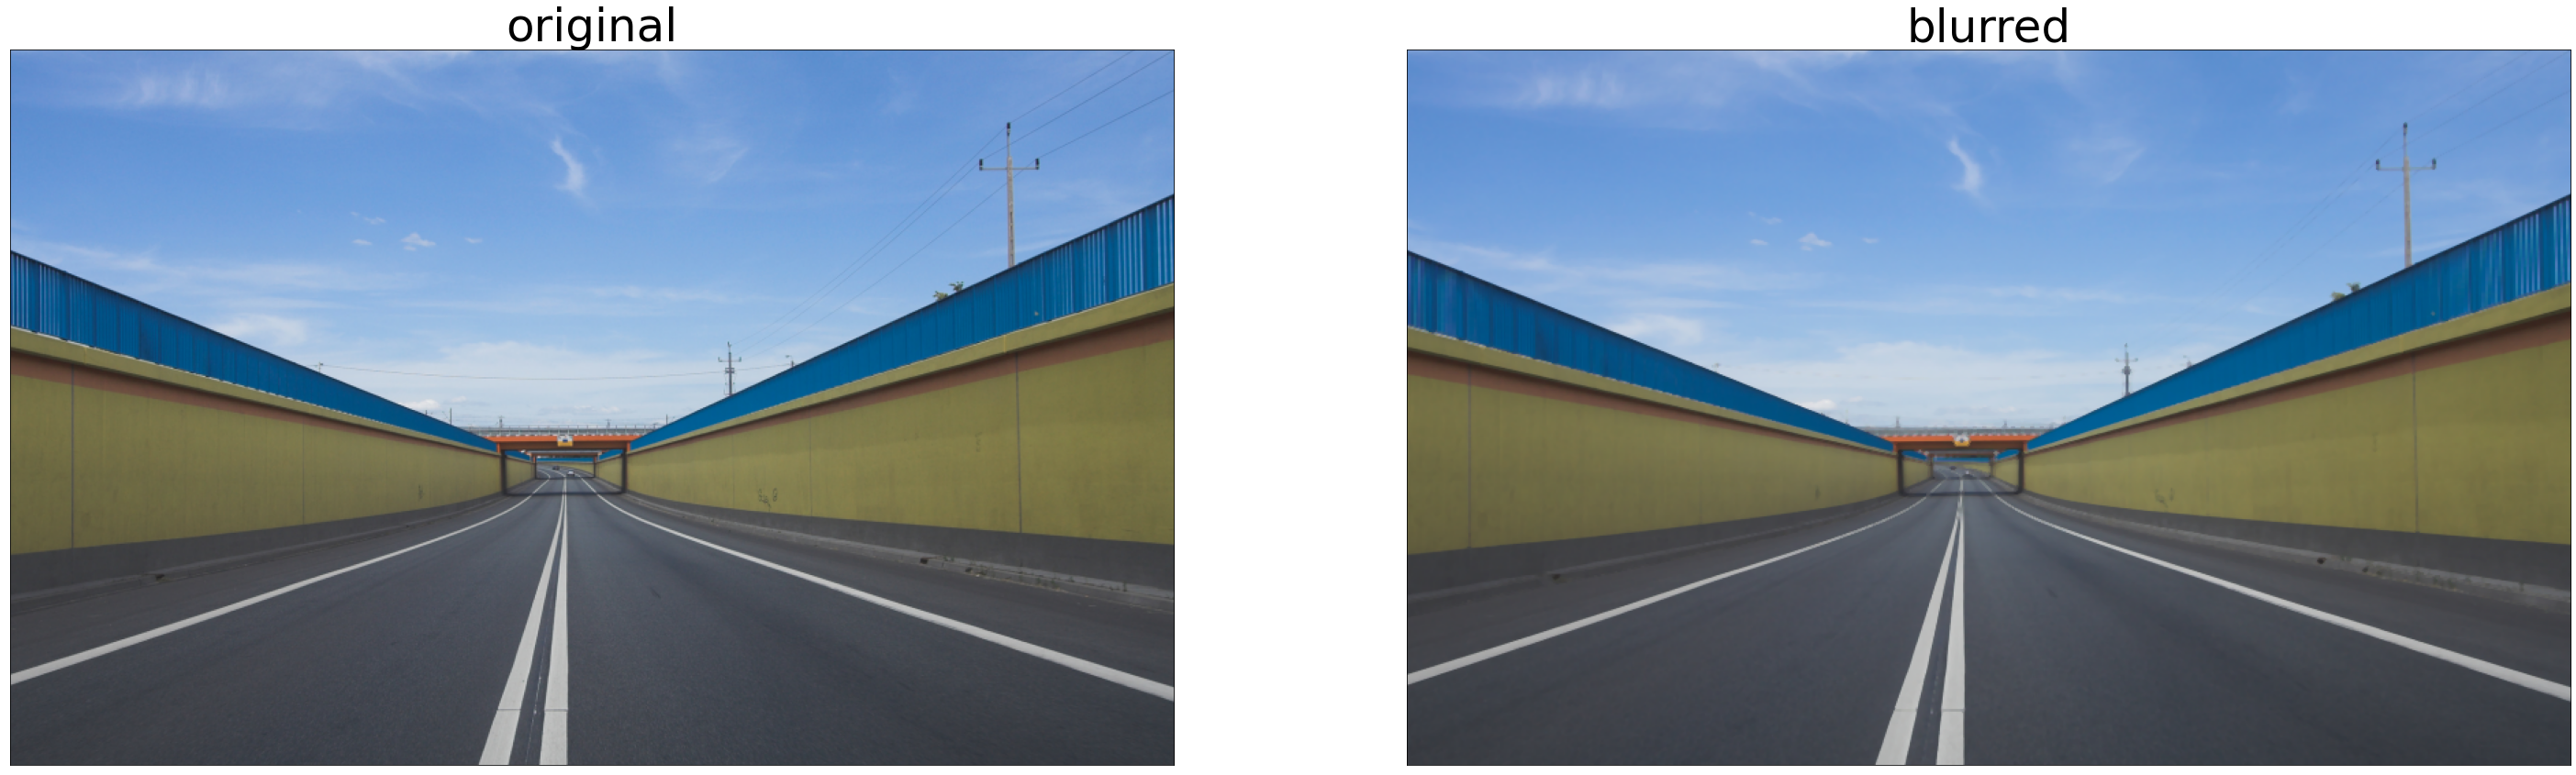

In [ ]:
median2 = median_filter(img2,3)
plot2(img2, median2, 'original', 'blurred')

# Edge detector

In [ ]:
def edge_detector(median):
  t_lower = 100  # Lower Threshold
  t_upper = 200  # Upper threshold
  edge = cv2.Canny(median, t_lower, t_upper)
  return edge

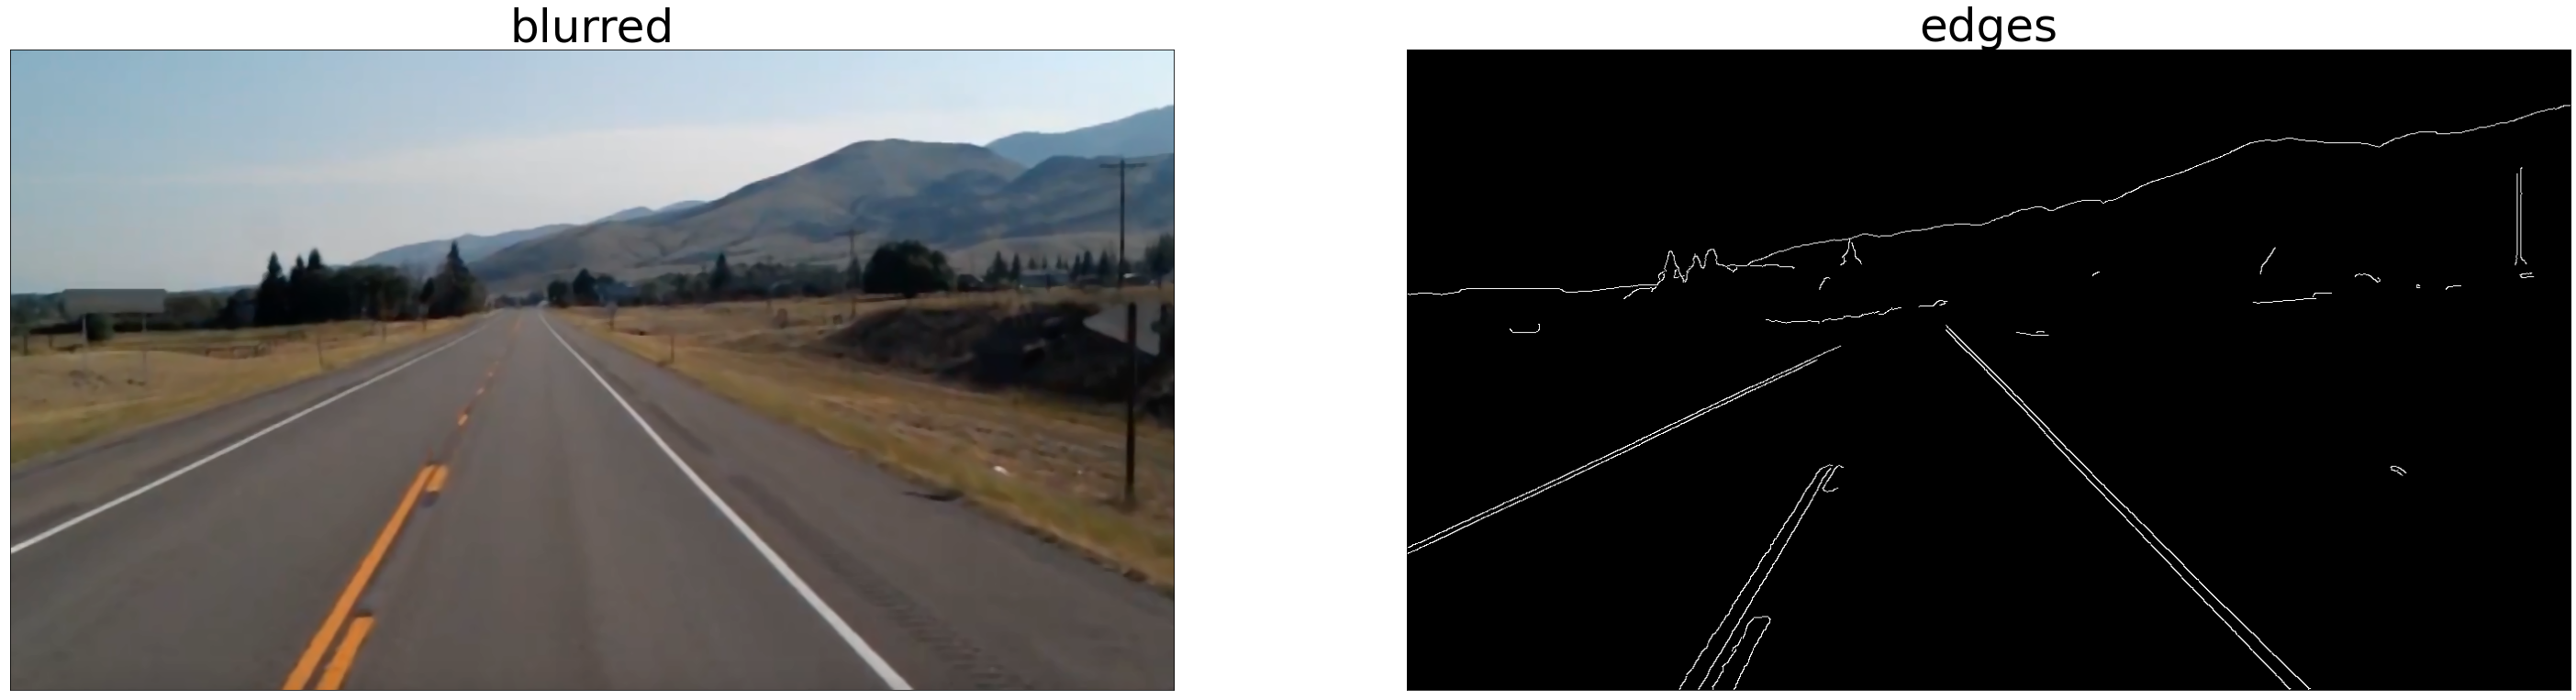

In [ ]:
edge1 = edge_detector(median1)
plot2(median1, edge1, 'blurred', 'edges', cmap2='gray')

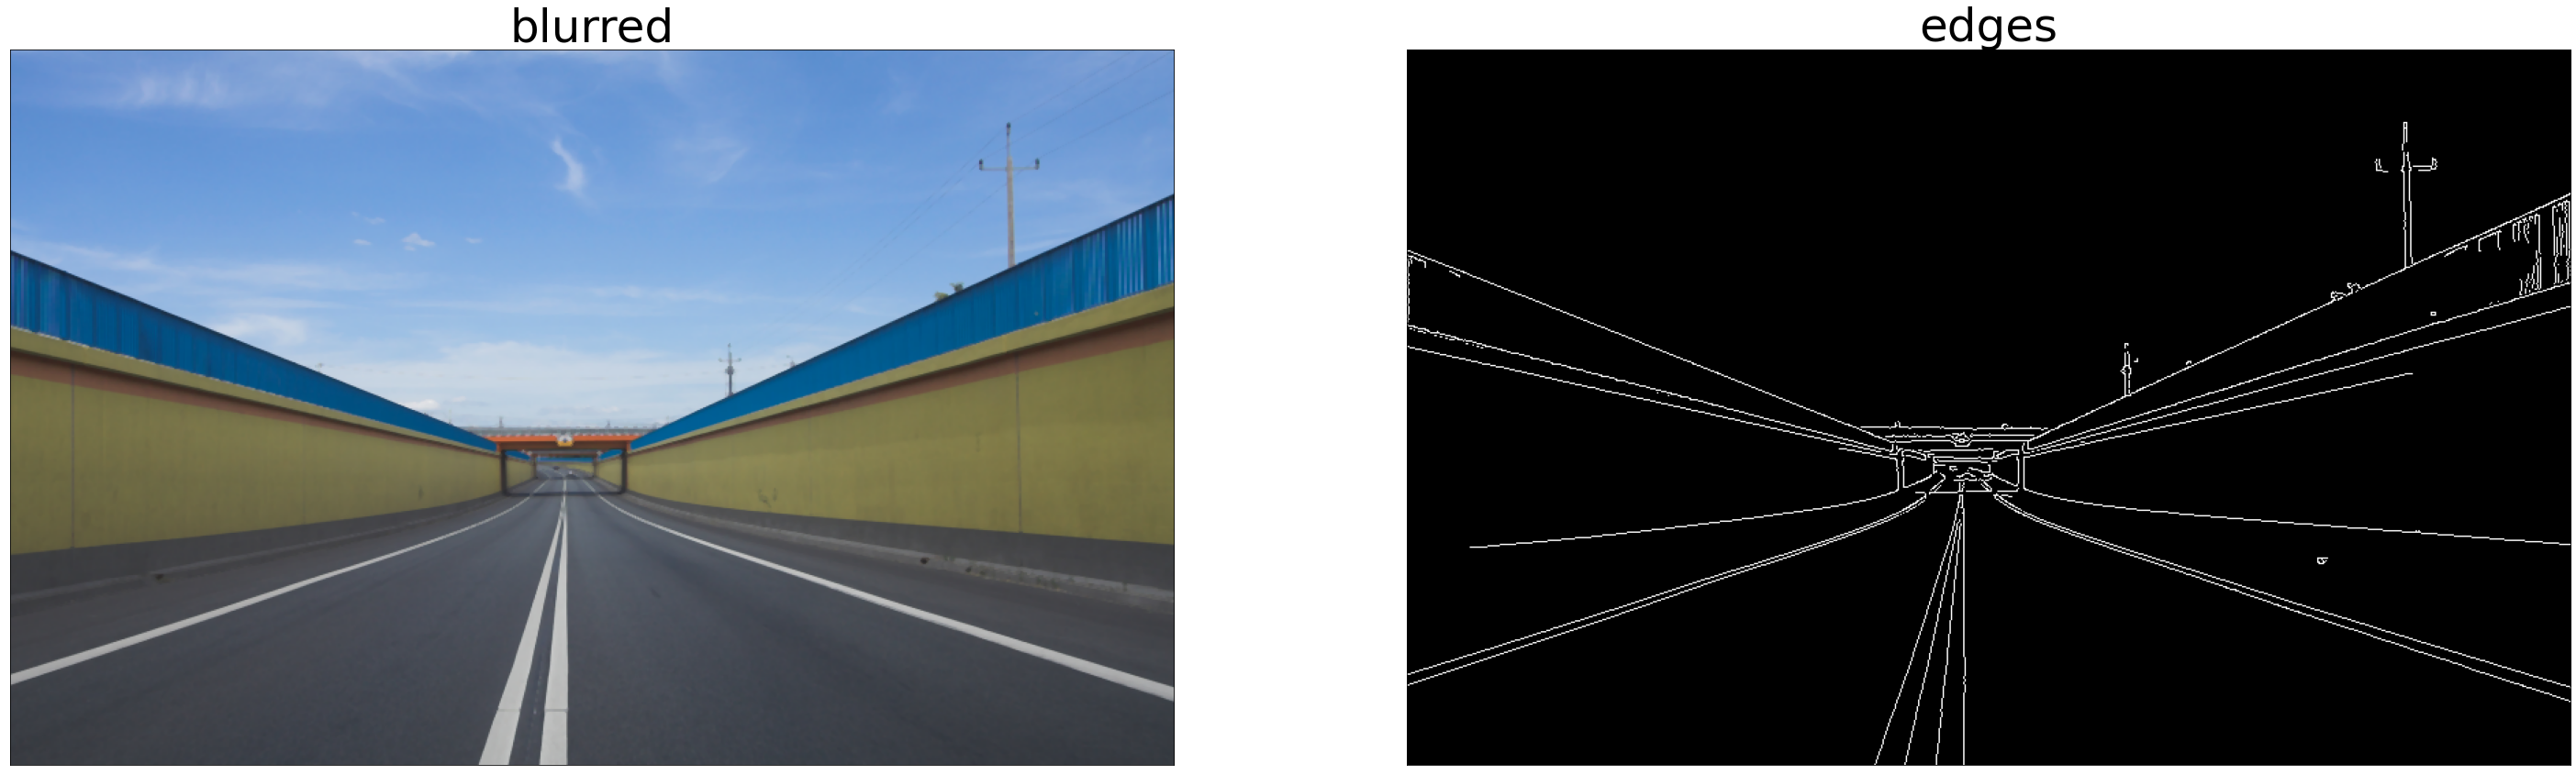

In [ ]:
edge2 = edge_detector(median2)
plot2(median2, edge2, 'blurred', 'edges', cmap2='gray')

# Region Of Interest

In [ ]:
def region_of_interest(edge, points):
  mask = np.zeros(edge.shape, dtype=np.uint8)
  points = np.array(points)
  cv2.fillPoly(mask, np.int32([points]), 255)
  roi = cv2.bitwise_and(edge, edge, mask=mask)
  return mask, roi

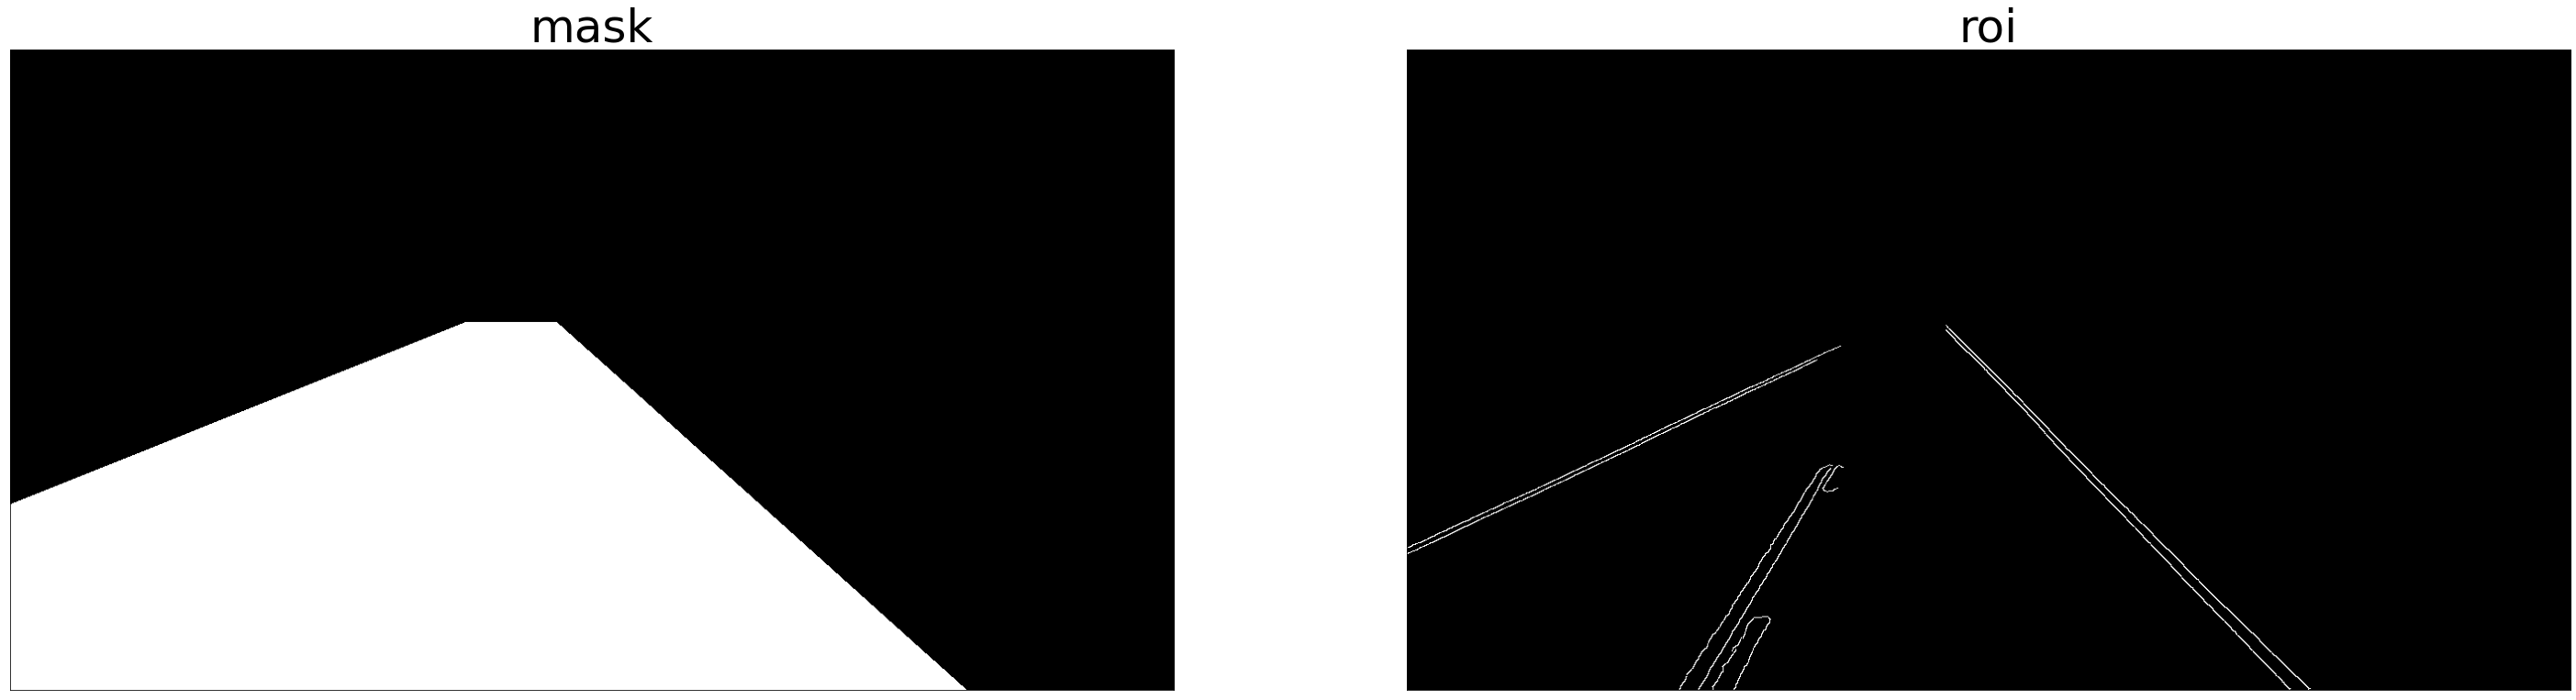

In [ ]:
points1 = [[0,704], [0,500], [500,300], [600,300],[1050,704]]
mask1, roi1 = region_of_interest(edge1, points1)
plot2(mask1, roi1, 'mask', 'roi', cmap1='gray', cmap2='gray')

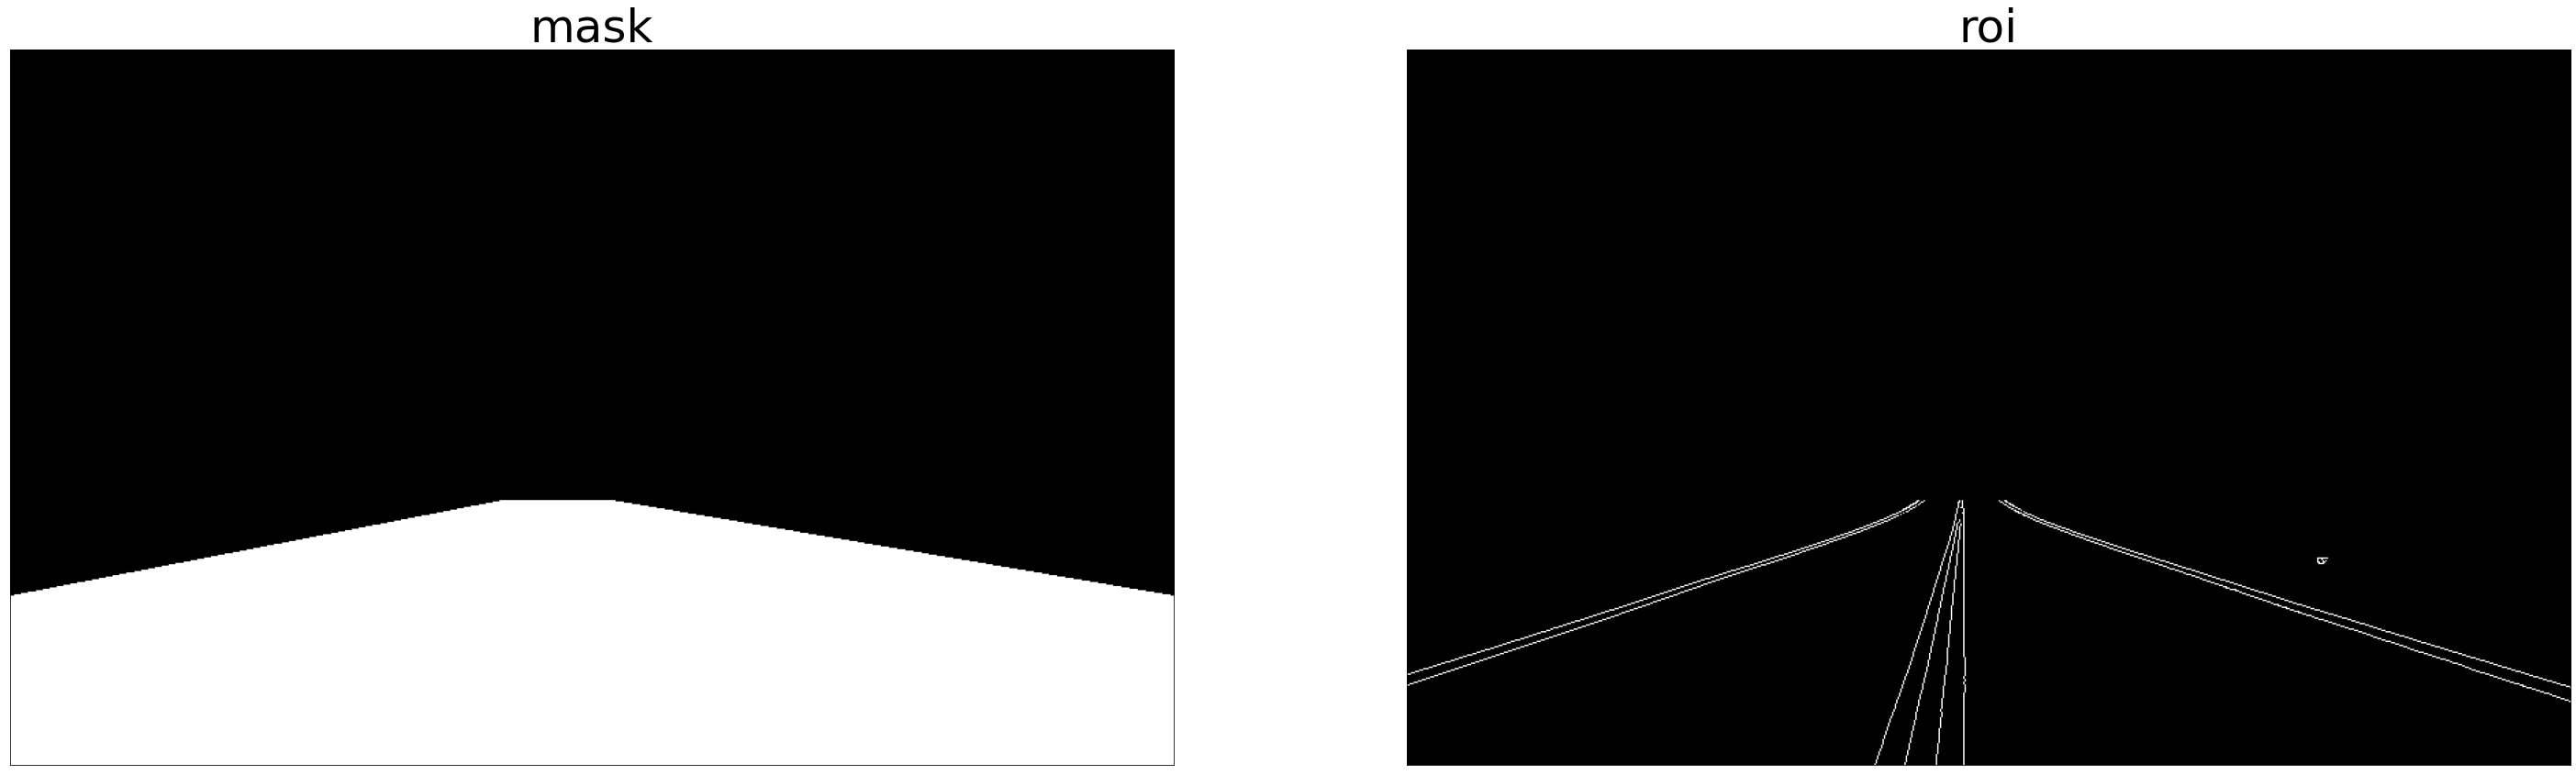

In [ ]:
points2 = [[852,524],[852,400],[440,330], [360,330] ,[0,400], [0,524]]
mask2, roi2 = region_of_interest(edge2, points2)
plot2(mask2, roi2, 'mask', 'roi', cmap1='gray', cmap2='gray')

# Hough transform

In [ ]:
def hough_transform(edge_img):

  y_idxs, x_idxs = np.nonzero(edge_img)  # (row, col) indexes to edges
  num_of_thetas = 180
  thetas = np.deg2rad(np.arange(0, num_of_thetas))
  cos_t = np.cos(thetas)
  sin_t = np.sin(thetas)
  
  height, width = edge_img.shape
  diag_len = int(np.ceil(np.sqrt(width * width + height * height)))
  accumulator = np.zeros((2*diag_len, num_of_thetas), dtype=np.uint64)

  for p in range(len(x_idxs)):
    x = x_idxs[p]
    y = y_idxs[p]

    for t in range(num_of_thetas):
        rho = round(x * cos_t[t] + y * sin_t[t]) + diag_len
        accumulator[rho, t] += 1

  return accumulator

In [ ]:
def hough_transform_vectorized(edge_img):
    thetas = np.deg2rad(np.arange(0, 180))
    width, height = edge_img.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))   
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_theta = np.cos(thetas)
    sin_theta = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator 
    accumulator = np.zeros((2 * diag_len, num_thetas))
    y_idxs, x_idxs = np.nonzero(edge_img)  # (row, col) indexes to edges
    
    # Vote in the hough accumulator
    xcosthetas = np.dot(x_idxs.reshape((-1,1)), cos_theta.reshape((1,-1)))
    ysinthetas = np.dot(y_idxs.reshape((-1,1)), sin_theta.reshape((1,-1)))
    rhosmat = np.round(xcosthetas + ysinthetas) + diag_len
    rhosmat = rhosmat.astype(np.int16)
    for i in range(num_thetas):
        rhos,counts = np.unique(rhosmat[:,i], return_counts=True)
        accumulator[rhos,i] = counts
    return accumulator

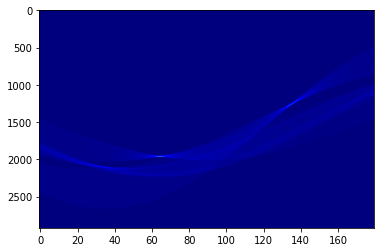

In [ ]:
acc1 = hough_transform_vectorized(roi1)
plt.imshow(acc1, aspect='auto', cmap='jet')

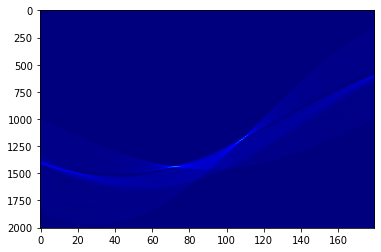

In [ ]:
acc2 = hough_transform_vectorized(roi2)
plt.imshow(acc2, aspect='auto', cmap='jet')

# Thresholding

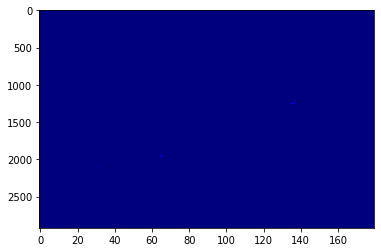

In [ ]:
acc1[acc1<200] = 0
plt.imshow(acc1, aspect='auto', cmap='jet')

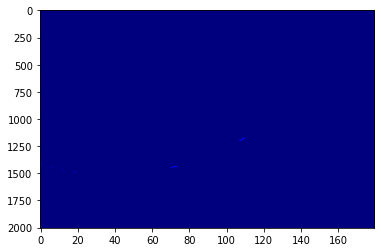

In [ ]:
acc2[acc2<100] = 0
plt.imshow(acc2, aspect='auto', cmap='jet')

# Non Max Suppression

In [ ]:
def nonMaximalSupress1(acc,NHoodSize):
    #
    dX, dY = NHoodSize
    M, N = acc.shape
    for x in range(0,M-dX+1):
        for y in range(0,N-dY+1):
            window = acc[x:x+dX, y:y+dY]
            if np.sum(window)==0:
                localMax=0
            else:
                localMax = np.amax(window)
            maxCoord=np.unravel_index(np.argmax(window), window.shape) + np.array((x,y))
            #suppress everything
            acc[x:x+dX, y:y+dY]=0
            #reset only the max
            acc[tuple(maxCoord)] = localMax

In [ ]:
nonMaximalSupress1(acc1, (20,10))
nonMaximalSupress1(acc2, (40,20))

# Drawing Line

In [ ]:
def drawing_line(acc,img, edge, mask): 
  lines = np.nonzero(acc)
  height, width = edge.shape
  diag_len = int(np.ceil(np.sqrt(width * width + height * height)))
  thetas = np.deg2rad(lines[1])
  rhos = lines[0] - diag_len
  org_img = img.copy()
  for rho,theta in zip(rhos,thetas):
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a*(rho)
      y0 = b*(rho)
      x1 = int(x0 + 500*(-b))
      y1 = int(y0 + 500*(a))
      x2 = int(x0 - 3000*(-b))
      y2 = int(y0 - 3000*(a))
      cv2.line(img,(x1,y1),(x2,y2),(222, 24, 189),7)

  masked_image = cv2.bitwise_and(img, img, mask= mask)
  org_img = cv2.bitwise_and(org_img, org_img, mask= np.invert(mask))
  output = cv2.addWeighted(masked_image,1,org_img,1,0)
  plt.imshow(output)

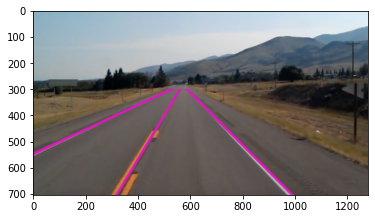

In [ ]:
drawing_line(acc1,img1, edge1, mask1)

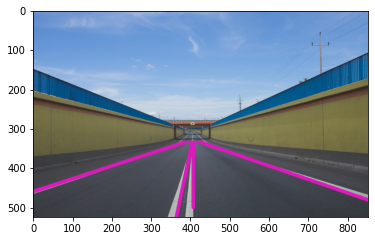

In [ ]:
drawing_line(acc2,img2, edge2, mask2)